In [3]:
import sys
sys.path.append("d:/junbo/rcan_code")

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from models.ukan import *


In [32]:
encoder = Encoder(in_channels=1, out_channels=256)
x = torch.randn(1, 1, 256, 256)
out = encoder(x)
t3 = out
print(out.shape)  

torch.Size([1, 256, 32, 32])


In [33]:
patch_embed1 = PatchEmbed(img_size=64, patch_size=7, stride=2, in_chans=256, embed_dim=320)
patch_embed2 = PatchEmbed(img_size=32, patch_size=7, stride=2, in_chans=320, embed_dim=512)


In [34]:

norm_layer=nn.LayerNorm
norm3 = norm_layer(320)
norm4 = norm_layer(512)

block1 = nn.ModuleList([KANBlock(
    dim=320,
    drop=0, drop_path=0, norm_layer=norm_layer
    )])

block2 = nn.ModuleList([KANBlock(
    dim=512,
    drop=0, drop_path=0, norm_layer=norm_layer
    )])

In [35]:
# tokenKAN-1
out, H, W = patch_embed1(out)

for i, blk in enumerate(block1):
    out = blk(out, H, W)

out = norm3(out)

out = out.reshape(1, H, W, -1).permute(0, 3, 1, 2).contiguous()
t4 = out
print(t4.shape)

torch.Size([1, 320, 16, 16])


In [36]:
# tokenKAN-2

out, H, W = patch_embed2(out)

for i, blk in enumerate(block2):
    out = blk(out, H, W)

out = norm4(out)

out = out.reshape(1, H, W, -1).permute(0, 3, 1, 2).contiguous()
t5 = out
print(t5.shape)

torch.Size([1, 512, 8, 8])


In [37]:
decoder1 = D_ConvLayer(512, 320)
decoder2 = D_ConvLayer(320, 256)

In [38]:
dblock1 = nn.ModuleList([KANBlock(
            dim=320,
            drop=0, drop_path=0, norm_layer=norm_layer
            )])

dblock2 = nn.ModuleList([KANBlock(
            dim=256,
            drop=0, drop_path=0, norm_layer=norm_layer
            )])


dnorm3 = norm_layer(320)
dnorm4 = norm_layer(256)

In [39]:
# DtokenKAN-1
out = F.relu(F.interpolate(decoder1(out), scale_factor=(2, 2), mode='bilinear'))
out = torch.add(out, t4)
_, _, H, W = out.shape
out = out.flatten(2).transpose(1, 2)
for i, blk in enumerate(dblock1):
    out = blk(out, H, W)
out = dnorm3(out)
out = out.reshape(1, H, W, -1).permute(0, 3, 1, 2).contiguous()


In [40]:
print(out.shape)

torch.Size([1, 320, 16, 16])


In [41]:
# DtokenKAN-2
out = F.relu(F.interpolate(decoder2(out),scale_factor=(2,2),mode ='bilinear'))

out = torch.add(out,t3)
_,_,H,W = out.shape
out = out.flatten(2).transpose(1,2)

for i, blk in enumerate(dblock2):
    out = blk(out, H, W)

out = dnorm4(out)
out1 = out.reshape(1, H, W, -1).permute(0, 3, 1, 2).contiguous()


In [42]:
print(out1.shape)

torch.Size([1, 256, 32, 32])


In [43]:
embed_dims = [256, 320, 512]

decoder3 = D_ConvLayer(embed_dims[0], embed_dims[0]//2)
decoder4 = D_ConvLayer(embed_dims[0]//2, embed_dims[0]//4) 
decoder5 = D_ConvLayer(embed_dims[0]//4, embed_dims[0]//8)  

encoder1 = ConvBlock(1, 64)
encoder2 = ConvBlock(64, 128)
encoder3 = ConvBlock(128, embed_dims[0])


In [44]:
### Encoder
### Conv Stage
### Stage 1
out = F.relu(F.max_pool2d(encoder1(x), 2, 2))
t1 = out
### Stage 2
out = F.relu(F.max_pool2d(encoder2(out), 2, 2))
t2 = out
### Stage 3
out = F.relu(F.max_pool2d(encoder3(out), 2, 2))
t3 = out

print(t1.shape, t2.shape, t3.shape)


torch.Size([1, 64, 128, 128]) torch.Size([1, 128, 64, 64]) torch.Size([1, 256, 32, 32])


In [45]:
out = F.relu(F.interpolate(decoder3(out1),scale_factor=(2,2),mode ='bilinear'))
print(out.shape)
out = torch.add(out,t2)
out = F.relu(F.interpolate(decoder4(out),scale_factor=(2,2),mode ='bilinear'))
print(out.shape)
out = torch.add(out,t1)
out = F.relu(F.interpolate(decoder5(out),scale_factor=(2,2),mode ='bilinear'))
print(out.shape)


torch.Size([1, 128, 64, 64])
torch.Size([1, 64, 128, 128])
torch.Size([1, 32, 256, 256])


In [46]:
final_conv = nn.Conv2d(in_channels=embed_dims[0]//8, out_channels=1, kernel_size=1)
out = final_conv(out)
print(out.shape)

torch.Size([1, 1, 256, 256])


Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


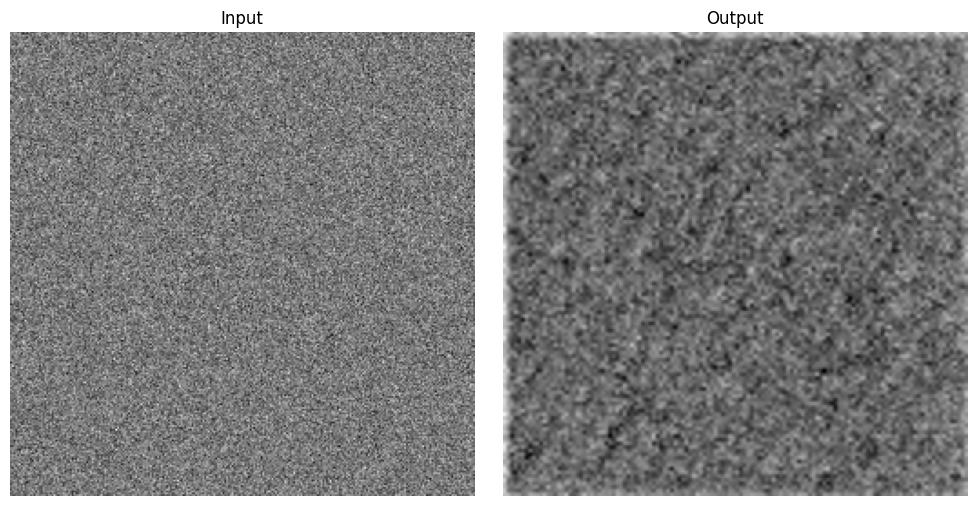

In [48]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 创建模型并加载到设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = U_KAN(in_channels=1).to(device)
model.eval()

# 构造输入：1张灰度图 (batch=1, channel=1, height=512, width=512)
input_tensor = torch.randn(1, 1, 256, 256).to(device)

# 前向传播
with torch.no_grad():
    output = model(input_tensor)

# 查看输入和输出形状
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output.shape}")

# 可视化输入和输出（确保是CPU张量）
input_img = input_tensor.squeeze().cpu().numpy()
output_img = output.squeeze().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_img, cmap='gray')
plt.title("Input")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(output_img, cmap='gray')
plt.title("Output")
plt.axis("off")

plt.tight_layout()
plt.show()

In [2]:
model = U_KAN(in_channels=1)  # 根据你的设置初始化模型

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 35,880,833
Trainable parameters: 35,880,833


In [ ]:
out = F.relu(F.interpolate(decoder2(out), scale_factor=(2, 2), mode='bilinear'))
    if out.shape != x4.shape:
        x4 = center_crop(x4, out)
    out = torch.add(out, x4)
    _, _, H, W = out.shape
    out = out.flatten(2).transpose(1, 2)

    for i, blk in enumerate(self.dblock2):
        out = blk(out, H, W)

    out = self.dnorm4(out)
    out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
